In [1]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageEnhance
import imageio.v2 as imageio
import seaborn as sns
from natsort import natsorted
from scipy.ndimage import gaussian_filter1d

## Import relevant libraries
import sys
sys.path.append('../../activedrops')
import pivdrops
pivdrops.set_plotting_style()

In [ ]:
def convert_cy5_gfp_to_8bit(data_path, condition, subcondition, min_frame, max_frame):
    # Base directory where the .tif files are located
    directory = f"{data_path}/{condition}/{subcondition}/original"

    # Directories for saving the converted images
    cy5_output_directory = f"{data_path}/{condition}/{subcondition}/cy5_8bit"
    gfp_output_directory = f"{data_path}/{condition}/{subcondition}/gfp_8bit"

    # Create the output directories if they don't exist
    if not os.path.exists(cy5_output_directory):
        os.makedirs(cy5_output_directory)
    if not os.path.exists(gfp_output_directory):
        os.makedirs(gfp_output_directory)

    # Pattern to match .tif files
    search_pattern = os.path.join(directory, "img_*.tif")

    # Get a sorted list of all .tif files to ensure they are processed in order
    tif_files = sorted(glob.glob(search_pattern))[min_frame:max_frame]

    for tif_file in tif_files:
        try:
            # Read the image using OpenCV
            # img = cv2.imread(tif_file, cv2.IMREAD_UNCHANGED)
            img = imageio.imread(tif_file) / 255

            # Convert the image to 8-bit
            img_8bit = img.astype('uint8') 

            # Extract the base name
            base_name = os.path.basename(tif_file)

            # Determine the output directory based on the file name
            if "cy5" in base_name:
                output_directory = cy5_output_directory
            elif "gfp" in base_name:
                output_directory = gfp_output_directory
            else:
                continue  # Skip files that do not match 'cy5' or 'gfp'

            # Generate the new file path in the appropriate '8bit' folder
            new_file_path = os.path.join(output_directory, base_name)

            # Save the 8-bit image
            cv2.imwrite(new_file_path, img_8bit)
        except Exception as e:
            print(f"Error processing {tif_file}: {e}")


In [ ]:
# def plot_mean_fluorescence_over_time(data_path, condition, subcondition, channel, time_interval=3, min_frame=0, max_frame=None, skip_frames=1):
#     """
#     Computes and plots the mean fluorescence intensity over time for a given set of images.

#     Args:
#     - data_path (str): Base directory where the images are stored.
#     - condition (str): Condition defining a subdirectory within the data path.
#     - subcondition (str): Subcondition defining a further subdirectory.
#     - channel (str): Channel specifying the fluorescence ('cy5' or 'gfp').
#     """
#     # Determine the directory path based on the channel
#     directory_path = os.path.join(data_path, condition, subcondition, f"{channel}_8bit")
    
#     # Get all .tif files in the folder
#     image_files = sorted(glob.glob(os.path.join(directory_path, "*.tif")))[min_frame:max_frame:skip_frames]
    
#     # Initialize a list to store results
#     intensities = []
#     frames = []
    
#     # Loop through each image file
#     for i, image_file in enumerate(image_files):
#         # Read the image
#         img = imageio.imread(image_file) 
        
#         # Compute the mean fluorescence intensity
#         mean_intensity = np.mean(img)
        
#         # Append results
#         frames.append(i)
#         intensities.append(mean_intensity)
    
#     # Create a DataFrame 
#     results_df = pd.DataFrame({
#         "frame": frames,
#         "mean_intensity": intensities - np.min(intensities)
#     })
    
#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.plot(results_df["frame"] * time_interval / 60, results_df["mean_intensity"], marker='o', linestyle='-', color='b')
#     plt.title(f"Motor expression over time \n{condition} - {subcondition} - {channel}")
#     plt.xlabel("time (min)")
#     plt.ylabel("Normalized Mean Fluorescence Intensity (A.U.)")
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.show()

#     return results_df



In [ ]:
cmap = plt.get_cmap('viridis')

# now disply the color map without yellow

# cmap = plt.get_cmap('viridis')


C:\Users\dalar\AppData\Local\Temp\ipykernel_18856\3064835068.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_file) #/ 2**16  # Normalize to 16-bit
C:\Users\dalar\AppData\Local\Temp\ipykernel_18856\3064835068.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_file) #/ 2**16  # Normalize to 16-bit
C:\Users\dalar\AppData\Local\Temp\ipykernel_18856\3064835068.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning

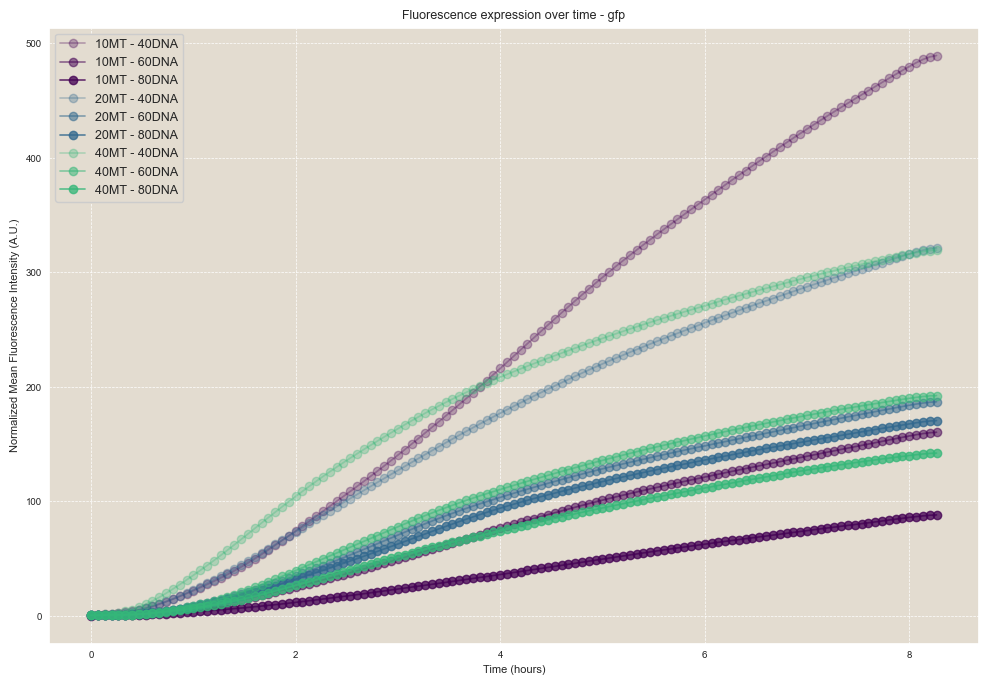

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

def plot_mean_fluorescence_over_time(data_path, conditions, subconditions, channel, time_interval=3, min_frame=0, max_frame=None, skip_frames=1, log_scale=False):
    """
    Computes and plots the mean fluorescence intensity over time for a given set of images across multiple conditions and subconditions,
    with visual grouping by condition and improved legend. Time is displayed in hours. The final plot, including all curves, is saved as a JPG file.

    Parameters:
    - data_path (str): Base path where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - channel (str): Channel name.
    - time_interval (int): Time interval between frames in minutes.
    - min_frame (int): Minimum frame number to process.
    - max_frame (int): Maximum frame number to process.
    - skip_frames (int): Number of frames to skip between plotted points.
    - log_scale (bool): Whether to plot the y-axis in log scale.
    """
    plt.figure(figsize=(12, 8))

    # Use a colormap to generate distinct colors for each condition
    cmap = plt.get_cmap('viridis')
    condition_colors = cmap(np.linspace(0, 1, len(conditions) + 1)[:-1])
    # Generate shades for subconditions within each condition
    for condition_idx, condition in enumerate(conditions):
        base_color = condition_colors[condition_idx]
        
        for sub_idx, subcondition in enumerate(subconditions):
            directory_path = os.path.join(data_path, condition, subcondition, "original")
            
            # files can be either img_00000****_cy5-4x_000 or img_00000****_gfp-4x_000.tif so load the appropriate channel
            if channel == "cy5":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*cy5-4x_000.tif")))[min_frame:max_frame:skip_frames]
            elif channel == "gfp":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*gfp-4x_000.tif")))[min_frame:max_frame:skip_frames]
            
            intensities = []
            frames = []
            
            for i, image_file in enumerate(image_files):
                img = imageio.imread(image_file) #/ 2**16  # Normalize to 16-bit
                mean_intensity = np.mean(img) 
                frames.append(i * skip_frames)  # Adjust frames slightly for visual separation
                intensities.append(mean_intensity)
            
            results_df = pd.DataFrame({
                "frame": frames,
                "mean_intensity": intensities - np.min(intensities)
            })
            
            # Apply Gaussian filter to mean_intensity for smoothing
            smoothed_intensities = gaussian_filter1d(results_df["mean_intensity"], sigma=2)  # Sigma controls the smoothing strength
            
            # Calculate shade for subcondition
            alpha = 0.3 + (sub_idx / len(subconditions)) * 0.7  # Adjust alpha for subcondition shading
            color = base_color * np.array([1, 1, 1, alpha])

            # Plot each condition and subcondition with smoothed data
            plt.plot(results_df["frame"] * time_interval / 60 / 60, smoothed_intensities, color=color, marker='o', linestyle='-', label=f"{condition} - {subcondition}")

    plt.title(f"Fluorescence expression over time - {channel}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Normalized Mean Fluorescence Intensity (A.U.)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    if log_scale:
        plt.yscale('log')  # Set y-axis scale to log scale

    # Determine the output path for saving the plot
    output_path = os.path.join(data_path, f"{channel}_mean_fluorescence_vs_time.jpg")
    plt.savefig(output_path, format='jpg', dpi=200)
    plt.show()  # Close the figure after saving to free resources

# Define your conditions and subconditions
conditions = ["10MT", "20MT", "40MT"]
subconditions = ["40DNA", "60DNA", "80DNA"]

# Call the function with the updated parameters
plot_mean_fluorescence_over_time(
    data_path="../../data/kif3_phases/",
    conditions=conditions,
    subconditions=subconditions,
    channel="gfp",
    time_interval=30,  # Assuming this is the time interval in minutes between frames
    min_frame=0,
    max_frame=None,
    skip_frames=8
)


In [10]:
def create_normalized_intensity_heatmap(data_path, condition, subcondition, channel, time_interval=3, min_frame=0, max_frame=None, vmax=None, skip_frames=1):
    """
    Reads each image as a matrix, creates and saves a heatmap representing the normalized pixel-wise fluorescence intensity.

    Args:
    - data_path (str): Base directory where the images are stored.
    - condition (str): Condition defining a subdirectory within the data path.
    - subcondition (str): Subcondition defining a further subdirectory.
    - channel (str): Channel specifying the fluorescence ('cy5' or 'gfp').
    - time_interval (int): Time interval in seconds between frames.
    - min_frame (int): Minimum frame number to start processing from.
    - max_frame (int, optional): Maximum frame number to stop processing at.
    """
    # Determine the directory paths based on the channel
    input_directory_path = os.path.join(data_path, condition, subcondition, f"{channel}_8bit")
    output_directory_path = os.path.join(data_path, condition, subcondition, "intensity_heatmap")
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    # Get all .tif files in the folder
    image_files = sorted(glob.glob(os.path.join(input_directory_path, "*.tif")))[min_frame:max_frame:skip_frames] 
    
    # Loop through each image file and create a heatmap
    for i, image_file in enumerate(image_files, start=min_frame):
        # Read the image into a numpy array
        intensity_matrix = imageio.imread(image_file) 

        # Plot the heatmap
        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(intensity_matrix, cmap='gray', interpolation='nearest', extent=[-2762/2, 2762/2, -2762/2, 2762/2], vmin=0, vmax=vmax)
        plt.colorbar(im, ax=ax, label='Normalized Fluorescence Intensity (A.U.)')
        plt.title(f"Time (min): {(i - min_frame) * time_interval / 60:.2f}. \n{condition} - {subcondition} - {channel}")
        plt.xlabel('x [um]')
        plt.ylabel('y [um]')
        
        # Save the heatmap
        heatmap_filename = f"heatmap_frame_{i}.tif"
        heatmap_path = os.path.join(output_directory_path, heatmap_filename)
        plt.savefig(heatmap_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close(fig)  # Close the figure to free memory
 

In [11]:
def create_annotated_image_movies(data_path, condition, subcondition, channel, frame_rate=30, max_frame=None):
    """
    Creates video files from processed and annotated images stored in a specified directory.

    Args:
    - data_path (str): Base path where the annotated images are stored.
    - condition (str): Condition under which the annotated images are stored.
    - subcondition (str): Subcondition under which the annotated images are stored.
    - channel (str): The specific channel being processed ('cy5' or 'gfp').
    - frame_rate (int, optional): Frame rate for the output video. Defaults to 30.
    - max_frame (int, optional): Maximum number of frames to be included in the video. If None, all frames are included.
    """


    images_dir = os.path.join(data_path, condition, subcondition, "intensity_heatmap")

    image_files = natsorted(glob.glob(os.path.join(images_dir, "*.tif")))

    if max_frame is not None:
        image_files = image_files[:max_frame]

    if not image_files:
        print("No images found for video creation.")
        return

    # Get the resolution of the first image (assuming all images are the same size)
    first_image = cv2.imread(image_files[0])
    video_resolution = (first_image.shape[1], first_image.shape[0])  # Width x Height

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out_path = os.path.join(data_path, condition, subcondition, f"{channel}_movie.avi")
    out = cv2.VideoWriter(out_path, fourcc, frame_rate, video_resolution)

    for file_path in image_files:
        img = cv2.imread(file_path)
        out.write(img)  # Write the image frame to the video

    out.release()
    print(f"Video saved to {out_path}")


In [12]:
# Example usage
data_path = "../../data/kif3_phases/"
condition = "10MT"
subcondition = "40DNA"

# convert_cy5_gfp_to_8bit(data_path, condition, subcondition, min_frame=0, max_frame=None)

In [13]:
min_frame = 0
max_frame = None

skip_frames = 8

time_interval = 30 * skip_frames
frame_rate = 120 / skip_frames


In [14]:
plot_mean_fluorescence_over_time(data_path, condition, subcondition, "gfp", time_interval=time_interval, min_frame=min_frame, max_frame=max_frame, skip_frames=skip_frames)


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 1200x800 with 0 Axes>

In [9]:
create_normalized_intensity_heatmap(data_path, condition, subcondition, "cy5", time_interval=time_interval, min_frame=0, max_frame=None, vmax=62, skip_frames=skip_frames)
create_annotated_image_movies(data_path, condition, subcondition, "cy5", frame_rate=frame_rate, max_frame=None)


No images found for video creation.


In [ ]:
data_path = "../../data/kif3_phases/"
condition = "20MT"
subcondition = "40DNA"

create_normalized_intensity_heatmap(data_path, condition, subcondition, "gfp", time_interval=time_interval, min_frame=0, max_frame=None, vmax=4, skip_frames=skip_frames)
create_annotated_image_movies(data_path, condition, subcondition, "gfp", frame_rate=frame_rate, max_frame=None)


In [ ]:
viz.process_all_conditions_and_subconditions(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel="cy5",
    time_interval=60,  # Adjust as needed
    skip_frames=1,
    vmax=13000,  # Adjust as needed
    frame_rate=120  # Adjust as needed
)
